# Exploration Loan Data from Prosper
## by Jannis

## Preliminary Wrangling

This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others

In [42]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import io

%matplotlib inline

In [55]:
# Loading the dataset
url = 'https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv'
response = requests.get(url).content
loan_data = pd.read_csv(io.StringIO(response.decode('utf-8')))
loan_data.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [54]:
# high-level overview of data shape and composition
print(loan_data.shape)
print(loan_data.dtypes)

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


### The structure of the dataset

The Data set contains 113,937 loans (rows) with 81 variables (columns) on each loan. Most variables are integers (numeric) or strings (objects). But the dataset also has some categorical variables: for example CreditGrade, ProsperRating, EmploymentStatus, LoanStatus, ProsperScore

(worst) ——> (best)

### Main features of interest in the dataset

The huge dataset with a lot of informaton (81 variables) allows me to have deeper look at the question what factors affect a loan’s outcome status (Cancelled, Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue)?

This is a very critical question for banks and loan companies in order to minimize the default risk and and to set the right interest rate (including setting a proper risk premium).

This investigation might help to find out what factors predict the outcome of a loan best. 
  


### Features in the dataset that will help support the investigation

I think the factors that have the most influence on predicting the outcome of a loan are:

 - Term (The length of the loan expressed in months)
 - ProsperScore (custom risk score)
 - EmploymentStatus (The employment status of the borrower)
 - StatedMonthlyIncome & MonthlyLoanPayment
 - IncomeRange
 - BorrowerAPR
 - BorrowerRate
 - LoanOriginalAmount
 - OpenCreditLines (Number of open credit line)
 - TotalProsperPaymentsBilled (number of on time payments the borrower made on Prosper loans at the time they created this listing)


#### Whereby I expect  to have  `ProsperScore`, `TotalProsperPaymentsBilled`, `LoanOriginalAmount`, `BorrowerRate`,  (high interest rate are associated with higher default risk) and the ratio of monthly income and monthly loan payment  (*StatedMonthlyIncome/MonthlyLoanPayment*) have  the strongest effect on the loan's outcome status.
 

In the first step I will create a copy of the dataset and create a new variable called ratio_income_loanPayment (ratio of monthly income and monthly loan payment)

In [50]:
print(loan_data_clean.StatedMonthlyIncome.head())
print(loan_data_clean.MonthlyLoanPayment.head())

0    3083.333333
1    6125.000000
2    2083.333333
3    2875.000000
4    9583.333333
Name: StatedMonthlyIncome, dtype: float64
0    330.43
1    318.93
2    123.32
3    321.45
4    563.97
Name: MonthlyLoanPayment, dtype: float64


In [51]:
# create a copy of the dataset
loan_data_clean = loan_data.copy()
# drop all variables that are not needed in the investigation to see how many observations I have left after 
#loan_data_clean = loan_data_clean.drop[[]] # really necceassry??
# in the first step I create a new variable ratio_income_loanPayment
loan_data_clean['ratio_income_loanPayment'] = (loan_data_clean.MonthlyLoanPayment / loan_data_clean.StatedMonthlyIncome)*100
# round the ratio to 2 decimals
loan_data_clean['ratio_income_loanPayment'] = loan_data_clean['ratio_income_loanPayment'].round(2)
print(loan_data_clean['ratio_income_loanPayment'].sample(3))
print(loan_data_clean['ratio_income_loanPayment'].describe())

16614     3.81
43641     3.65
92159    11.75
Name: ratio_income_loanPayment, dtype: float64
count    113922.00
mean           inf
std            NaN
min           0.00
25%           2.86
50%           4.96
75%           7.86
max            inf
Name: ratio_income_loanPayment, dtype: float64


## Univariate Exploration

I'll start by looking at the distribution of the main variable of interest ProsperScore, TotalProsperPaymentsBilled, BorrowerRate and ratio_income_loanPayment


> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.




> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

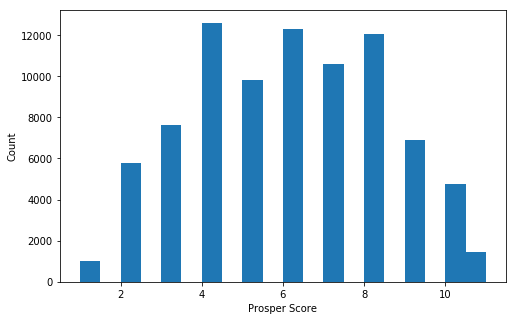

In [57]:
# Histogramm Prosper Score
binsize = 0.5
bins = np.arange(1, loan_data.ProsperScore.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_data_clean, x = 'ProsperScore', bins = bins)
plt.xlabel('Prosper Score')
plt.ylabel('Count')
plt.show()

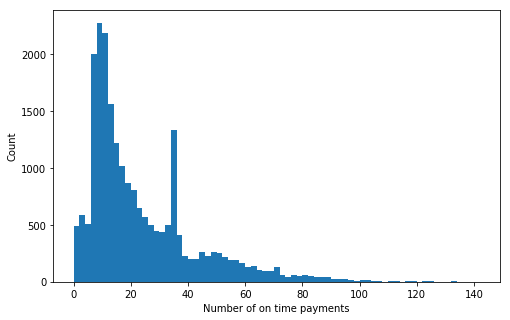

In [61]:
# Histogramm TotalProsperPaymentsBilled (Number of on time payments)
binsize = 2
bins = np.arange(loan_data.TotalProsperPaymentsBilled.min(), loan_data.TotalProsperPaymentsBilled.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_data_clean, x = 'TotalProsperPaymentsBilled', bins = bins)
plt.xlabel('Number of on time payments')
plt.ylabel('Count')
plt.show()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!